# Implicit Neural Representations (INR) for CT reconstruction

**For Colab user**

install astra-toolbox, tomosipo
**This may take up to 5 minutes!**

In [1]:
! apt install build-essential autoconf libtool
! pip install cython
! git clone https://github.com/astra-toolbox/astra-toolbox.git
! cd astra-toolbox/build/linux && ./autogen.sh && ./configure --with-cuda=/usr/local/cuda --with-python --with-install-type=module
! cd astra-toolbox/build/linux && make install -j 4
! pip install git+https://github.com/ahendriksen/tomosipo.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
autoconf is already the newest version (2.71-2).
autoconf set to manually installed.
build-essential is already the newest version (12.9ubuntu3).
Suggested packages:
  libtool-doc gcj-jdk
The following NEW packages will be installed:
  libtool
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 164 kB of archives.
After this operation, 1,227 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Fetched 164 kB in 1s (119 kB/s)
Selecting previously unselected package libtool.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libtool_2.4.6-15build2_all.deb ...
Unpacking libtool (2.4.6-15build2) ...
Setting up libtool (2.4.6-15build2) ...
Processing triggers for man-db (2.10.2-1) ...
Cloning into 'astra-toolbox'...
remote: Enumerating objects: 11

In [3]:
import sys
sys.path.append('/usr/local/lib/python3.10/dist-packages/astra_toolbox-2.1.3-py3.10-linux-x86_64.egg')

import packages

In [4]:
import torch
import torch.nn as nn
import tomosipo as ts
import numpy as np
from imageio import imread, imwrite
from tomosipo.torch_support import to_autograd
import matplotlib.pyplot as plt
from tqdm import tqdm
import astra
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


**For Colab user**:

Option 1: To access the image, please follow the instructions:


1.   Save the [folder](https://drive.google.com/drive/folders/1larjCPxZ-e33B3UjjhiBUG0OAyF19aj3?usp=drive_link) to your own google drive by "**Add to My Drive**" in the opened links
2.   Use the **code block below** to mount the files with the directory in your drive

In [7]:
from google.colab import drive
drive.mount('/content/drive/')
!cp "/content/drive/MyDrive/MLtutorial@Lorentz/lung_small.png" "./lung_small.png"

Mounted at /content/drive/


Option 2:
 **Warning!** This is often slower and dependent on the internet connection! Only consider it when the first option doesn't work

1.  Clone the files from github repostory [MLtutorial@Lorentz](https://github.com/jiayangshi/MLtutorial-Lorentz)
2.   Use the **code block below** to upload the files to current colab notebook



In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

define the MLP - Siren
Sitzmann et al., NIPS 2020

In [8]:
class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()

    def init_weights(self):
        b = 1 / \
            self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)


class SIREN(nn.Module):
    def __init__(self, network_depth, network_width, network_input_size, network_output_size):
        super(SIREN, self).__init__()

        num_layers = network_depth
        hidden_dim = network_width
        input_dim = network_input_size
        output_dim = network_output_size

        layers = [SirenLayer(input_dim, hidden_dim, is_first=True)]
        for i in range(1, num_layers - 1):
            layers.append(SirenLayer(hidden_dim, hidden_dim))
        layers.append(SirenLayer(hidden_dim, output_dim, is_last=True))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)

        return out

define the positional encoder
Fourier encoding for the input positions

In [9]:
class PositionalEncoder():
    def __init__(self, embedding_size=256, coordinates_size=2, scale=4, device='cuda'):
        self.B = torch.randn((embedding_size, coordinates_size)) * scale
        self.B = self.B.to(device)

    def embedding(self, x):
        x_embedding = (2. * np.pi * x) @ self.B.t()
        x_embedding = torch.cat([torch.sin(x_embedding), torch.cos(x_embedding)], dim=-1)
        return x_embedding

define the position generator
it produces coordinates of all positions

In [10]:
def create_grid_2d(h, w):
    grid_y, grid_x = torch.meshgrid([torch.linspace(0, 1, steps=h), \
                                    torch.linspace(0, 1, steps=w)])
    grid = torch.stack([grid_y, grid_x], dim=-1)
    return grid

In [11]:
# positional enoder
encoder = PositionalEncoder(embedding_size=128, coordinates_size=2, scale=4)

In [12]:
grid = create_grid_2d(256,256)
print(f'grid shape: {grid.shape}')
grid = grid.to(device)
encode_grid = encoder.embedding(grid)
print(f'encode_grid shape: {encode_grid.shape}')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


grid shape: torch.Size([256, 256, 2])
encode_grid shape: torch.Size([256, 256, 256])


In [26]:
epochs = 20000

model = SIREN(network_depth=8, network_width=128, network_input_size=256, network_output_size=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001 , betas=(0.9, 0.999), weight_decay=0)
model = model.to(device)
mse_loss = nn.MSELoss()

define tomographic operators in tomosipo

In [14]:
angles = np.linspace(0, np.pi, 40, endpoint=False)
vg = ts.volume(shape=(1, 256, 256), size=(1, 256, 256))
pg = ts.parallel(angles=angles, shape=(1, 256), size=(1, 256))
A = ts.operator(vg, pg)
f = to_autograd(A, is_2d=True)

Create circle mask to remove the the corners

In [15]:
# ref: tomopy.misc.corr.circ_mask https://tomopy.readthedocs.io/en/latest/_modules/tomopy/misc/corr.html#circ_mask
def _get_mask(dx, dy, ratio):
    """
    Calculate 2D boolean circular mask.

    Parameters
    ----------
    dx, dy : int
        Dimensions of the 2D mask.

    ratio : int
        Ratio of the circle's diameter in pixels to
        the smallest mask dimension.

    Returns
    -------
    ndarray
        2D boolean array.
    """
    rad1 = dx / 2.
    rad2 = dy / 2.
    if dx < dy:
        r2 = rad1 * rad1
    else:
        r2 = rad2 * rad2
    y, x = np.ogrid[0.5 - rad1:0.5 + rad1, 0.5 - rad2:0.5 + rad2]
    return x * x + y * y < ratio * ratio * r2

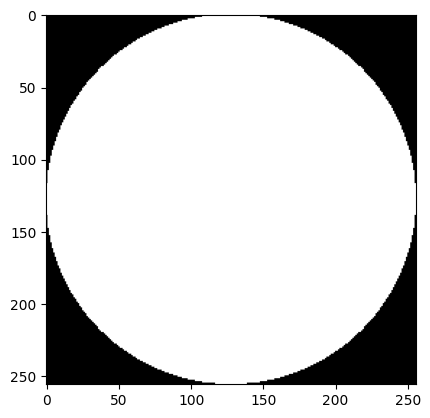

In [16]:
mask_np = _get_mask(256,256,1)
mask = torch.tensor(mask_np, dtype=torch.float32, device=device)
plt.imshow(mask.cpu().numpy(), cmap='gray')

create projection using forward operator f

In [17]:
img = imread('lung_small.png')
img = img / img.max()
# img = np.expand_dims(img, axis=0)
print(f"Shape of img: {img.shape}")
img = torch.tensor(img, dtype=torch.float32)
projs = f(img)
print(f"Shape of projs: {projs.shape}")
projs = projs.to(device)

Shape of img: (256, 256)
Shape of projs: torch.Size([40, 256])


<ipython-input-17-ceb6ca258986>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('lung_small.png')


Text(0.5, 1.0, 'Projections')

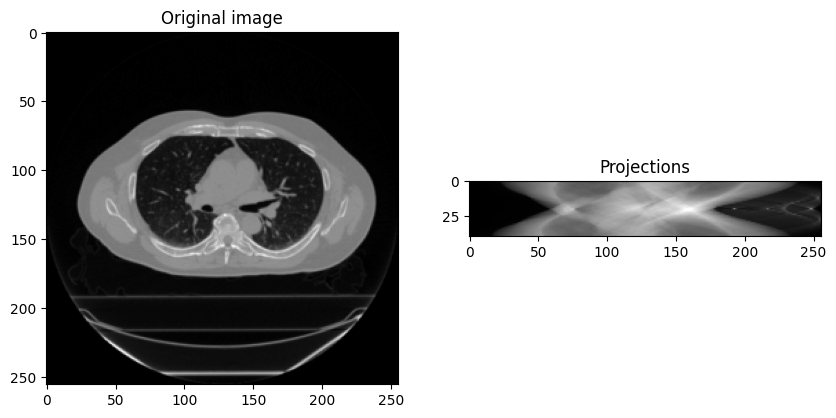

In [18]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(projs.cpu().numpy(), cmap='gray')
plt.title('Projections')

Optimization

  0%|          | 0/20000 [00:00<?, ?it/s]

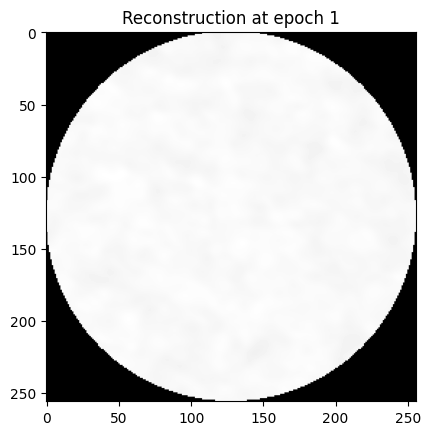

 10%|▉         | 1996/20000 [00:51<07:39, 39.15it/s]

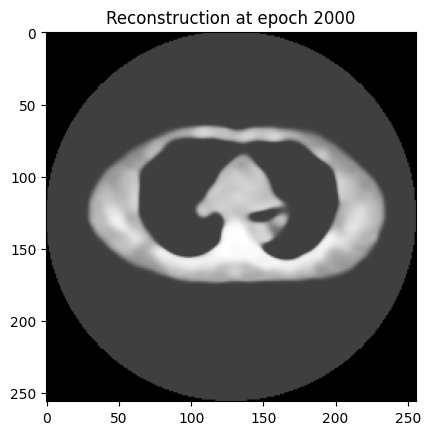

 20%|█▉        | 3998/20000 [01:42<06:50, 38.94it/s]

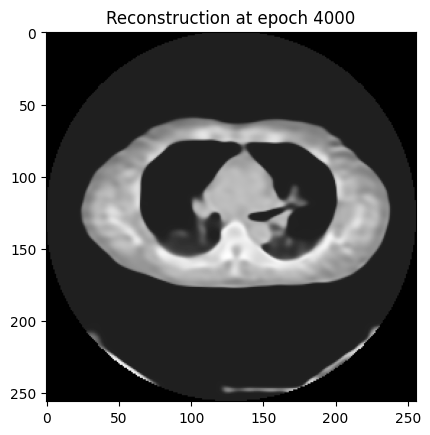

 30%|██▉       | 5997/20000 [02:34<05:59, 38.99it/s]

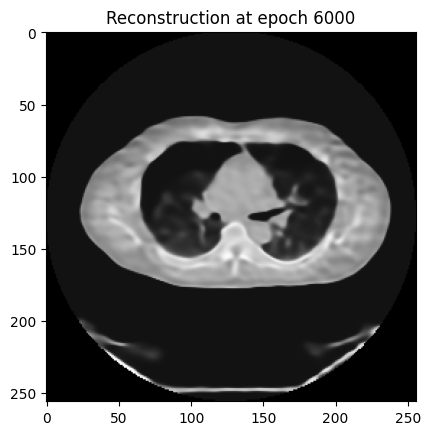

 40%|███▉      | 7999/20000 [03:26<05:05, 39.32it/s]

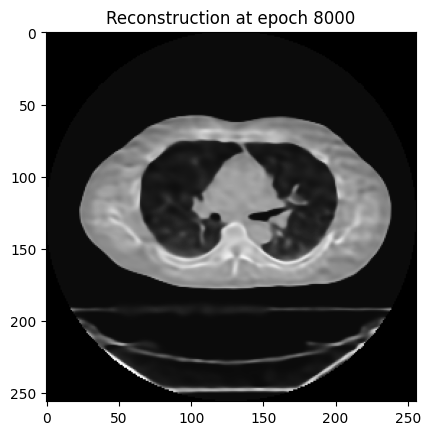

 50%|████▉     | 9999/20000 [04:17<04:15, 39.09it/s]

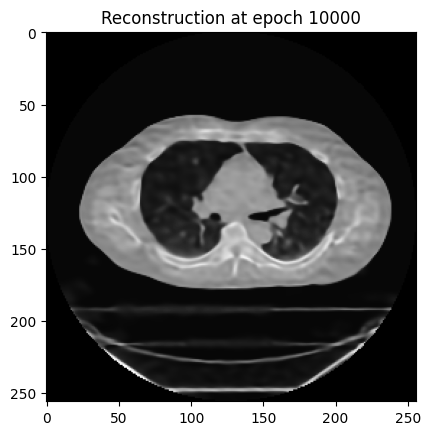

 60%|█████▉    | 11999/20000 [05:09<03:27, 38.64it/s]

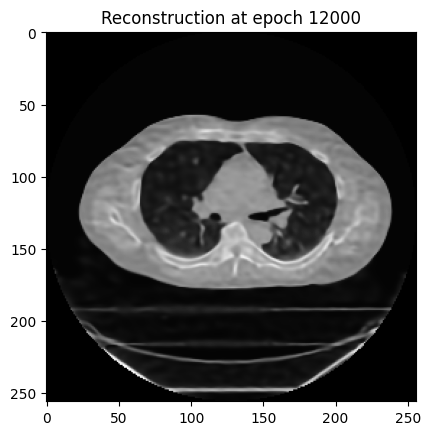

 70%|██████▉   | 13997/20000 [06:00<02:33, 39.04it/s]

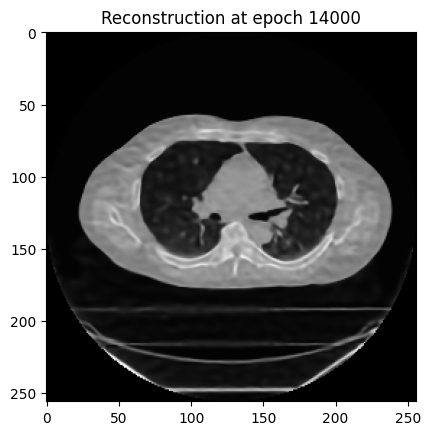

 80%|███████▉  | 15999/20000 [06:52<01:42, 39.09it/s]

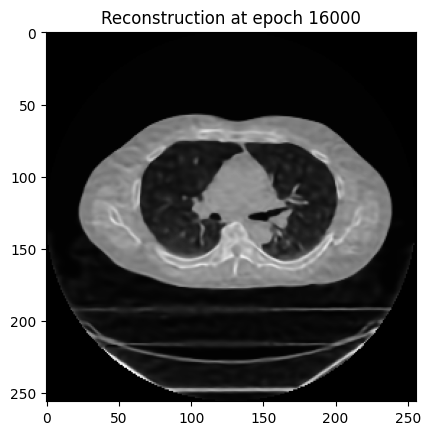

 90%|████████▉ | 17996/20000 [07:43<00:51, 38.73it/s]

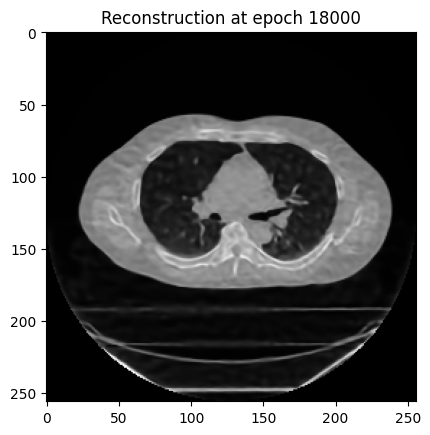

100%|█████████▉| 19997/20000 [08:35<00:00, 38.96it/s]

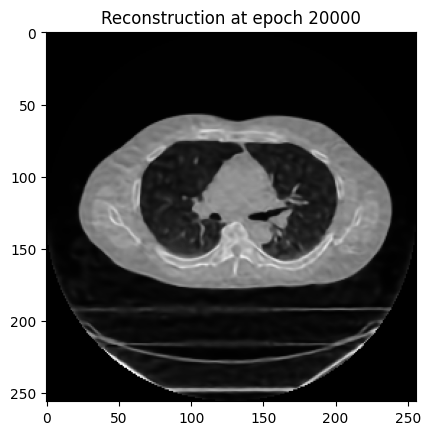

100%|██████████| 20000/20000 [08:35<00:00, 38.78it/s]


In [27]:
for epoch in tqdm(range(epochs)):
    if epoch == 0 or (epoch + 1) % 2000 == 0:
        model.eval()
        with torch.no_grad():
            test_output = model(encode_grid)
            test_output = torch.mul(test_output.squeeze(-1), mask)
            plt.imshow(test_output.detach().cpu().numpy(), cmap='gray')
            plt.title(f"Reconstruction at epoch {epoch + 1}")
            plt.show()
            plt.close()
            # uncomment to save images
            # imwrite(f"reconstruction_epoch_{epoch + 1}.png", test_output.detach().cpu().numpy())

    model.train()
    optimizer.zero_grad()
    train_output = model(encode_grid)
    train_output = torch.mul(train_output.squeeze(-1), mask)
    train_projs = f(train_output)
    train_loss = mse_loss(train_projs, projs)
    train_loss.backward()
    optimizer.step()


Comparison: FBP and SIRT

In [23]:
# angles = np.linspace(0, np.pi, 40, endpoint=False)

vg_astra = astra.create_vol_geom(256, 256)
pg_astra = astra.create_proj_geom('parallel', 1.0, 256, angles)
proj_id = astra.create_projector('cuda', pg_astra, vg_astra)
W = astra.OpTomo(proj_id)


In [24]:
recon_fbp = W.reconstruct('FBP_CUDA',projs.cpu().numpy())
recon_sirt = W.reconstruct('SIRT_CUDA',projs.cpu().numpy(),1000,{'MinConstraint':0,'MaxConstraint':1})

recon_fbp = recon_fbp * mask_np
recon_sirt = recon_sirt * mask_np
recon_fbp = recon_fbp[::-1,:]
recon_sirt = recon_sirt[::-1,:]

plot all recons

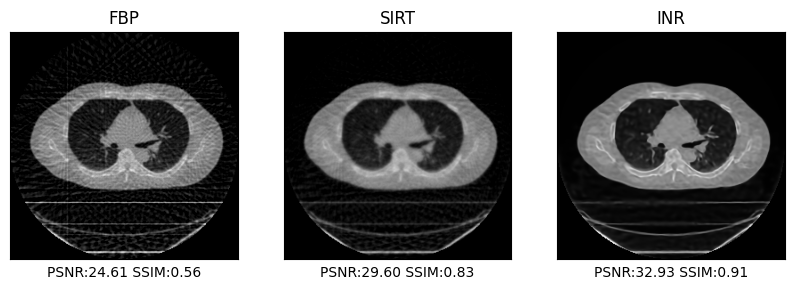

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(recon_fbp, vmin=0, vmax=1, cmap='gray')
plt.title('FBP')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(recon_fbp,img.numpy(),data_range=1):.2f} SSIM:{ssim(recon_fbp,img.numpy(),data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 2)
plt.imshow(recon_sirt, vmin=0, vmax=1, cmap='gray')
plt.title('SIRT')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(recon_sirt,img.numpy(),data_range=1):.2f} SSIM:{ssim(recon_sirt,img.numpy(),data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 3)
plt.imshow(test_output.detach().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('INR')
plt.xlabel('')
plt.ylabel('')
plt.xlabel(f"PSNR:{psnr(test_output.detach().cpu().numpy(),img.numpy(),data_range=1):.2f} SSIM:{ssim(test_output.detach().cpu().numpy(),img.numpy(),data_range=1):.2f}", ha='center')
plt.xticks([])
plt.yticks([])

plt.show()